<a href="https://colab.research.google.com/github/alejo14171/PLN/blob/main/Preprocesamiento_de_textos_%26_exploraci%C3%B3n_y_clasificaci%C3%B3n_de_documentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Preprocesamiento de textos & exploración y clasificación de documentos

**Objetivo**

Este taller busca afianzar los conceptos basicos de los temas cubiertos hasta esta semana en el curso de Técnicas de Procesamiento de Lenguaje Natural. Los objetivos específicos de este taller son:


1.   Preprocesar y limpiar los textos que conforman un corpus.
2.   Realizar tareas de tokenizacion,  ́ stemming, lematizacion y eliminación de stop words en documentos.
3.  Calcular los modelos estadísticos de lenguaje por medio de las frecuencias y las probabilidades de ocurrencia de palabras y secuencias de palabras (n-grams) y analizar las distintas posibilidades de uso de estos modelos.
4.  Representar los documentos de un corpus en el modelo de espacio vectorial.
5. Explorar tecnicas de clasificación de documentos basadas en el modelo de bolsa de palabras.

#### Notas aclaratoria:
Primer paso antes de ejecutar todo es cargar el corpus en el drive, o subirlo como archivo. En la primera celda se carga desde el drive configurando la ruta al archivo.

Eliminé la tabla de contenido del cuento para poder separarlo más facil, en esta estaban todos los capítulos. También cambié una palabra del cuento que se mencionaba en la linea 5694, la palabra era "CHAPTER 1", la cambié por "CHAPTER I", con el fin de que no me hiciera split en ese punto. También borré todo lo que iba después de "END OF THE PROJECT GUTENBERG EBOOK MOBY-DICK; OR THE WHALE", con el fin de no tomar esa parte en el último capítulo.

Si se corre todo el notebook este se va a detener esperando su input en el punto 10, de la implementación de un corrector ortográfico. También se demora un poco en algunas celdas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

mi_ruta_al_corpus = '/content/drive/MyDrive/Colab Notebooks/PLN/Taller 1/moby_dick.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!pip install pyspellchecker

from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.linalg import svd
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import gensim

import os
import re
import glob
import random
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.0 MB/s eta 0:00:00


## Importación y partición del corpus en capítulos

In [ ]:
# Lee el archivo de texto de Moby Dick:
with open(mi_ruta_al_corpus, "r", encoding="utf-8") as file:
    text = file.read()

# Encuentra todos los capítulos utilizando expresiones regulares y guarda los resultados en una lista:
chapters = re.split(r"\bCHAPTER\b\s*\d{1,3}", text, flags=re.IGNORECASE)[1:]  # Ignora el contenido antes del primer capítulo

corpus_directory = "moby_dick_corpus"
if not os.path.exists(corpus_directory):
    os.mkdir(corpus_directory)

for i, chapter in enumerate(chapters):
    filename = f"Chapter_{i+1:03}.txt"
    filepath = os.path.join(corpus_directory, filename)

    with open(filepath, "w", encoding="utf-8") as file:
        file.write(chapter.strip())

## 1- Normalización

Normalice el formato de sus textos (pase todos los textos a letras minusculas).

Tener en cuenta que la separación de los capítulos es una carpeta que se crea en la anterior celda en la carpeta content.

In [ ]:
corpus = []

for file in sorted(glob.glob("/content/moby_dick_corpus/Chapter_*.txt")):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read().lower()  # Convertir el texto a minúsculas
        corpus.append(text)


# Verificar los primeros elementos del corpus
print(len(corpus), 'capitulos tiene el corpus')
print(corpus[0][:200]) # Imprime los primeros 200 caracteres del primer capítulo

135 capitulos tiene el corpus
. loomings.

call me ishmael. some years ago—never mind how long precisely—having
little or no money in my purse, and nothing particular to interest me
on shore, i thought i would sail about a little 


## 2- Segmentar el corpus por frases y guardarlas en un txt

Notas mías:
Por defecto, strip() elimina todos los caracteres de espacio en blanco (espacios, tabulaciones, saltos de línea, etc.) en ambos extremos de la cadena. También es posible especificar un conjunto de caracteres que se deben eliminar en lugar de los espacios en blanco.

In [ ]:
def segmentar_frases(texto):
    separadores = r'[.!?;,]'
    frases = re.split(separadores, texto)
    return [frase.strip() for frase in frases if frase.strip() != '']

frases_corpus = []

for capitulo in corpus:
    frases_capitulo = segmentar_frases(capitulo)
    frases_corpus.extend(frases_capitulo)

with open('frases.txt', 'w', encoding='utf-8') as f:
    for frase in frases_corpus:
        f.write(f'{frase}\n')

# Imprimiendo las primeras frases del archivo frases.txt
with open('frases.txt', 'r', encoding='utf-8') as f:
    for _ in range(10):
        print(f.readline().strip())

loomings
call me ishmael
some years ago—never mind how long precisely—having
little or no money in my purse
and nothing particular to interest me
on shore
i thought i would sail about a little and see the watery part
of the world
it is a way i have of driving off the spleen and
regulating the circulation


## 3- Segmentación
Segmente sus documentos a nivel de palabra, elimine signos de puntuación y caracteres no alfabéticos. Calcule el número de tokens (running words) que hay en sus textos y el número de palabras distintas (vocabulario).

In [ ]:
def segmentar_palabras(texto):
    return re.findall(r'\b[a-zA-Z]+\b', texto) # Retorna una lista con caracteres alfanuméricos

tokens_corpus = []
vocabulario = set()

for capitulo in corpus:
    palabras_capitulo = segmentar_palabras(capitulo)
    tokens_corpus.extend(palabras_capitulo)
    vocabulario.update(palabras_capitulo)

numero_tokens = len(tokens_corpus)
numero_vocabulario = len(vocabulario)

print(f'Número de tokens (running words): {numero_tokens}')
print(f'Número de palabras distintas (vocabulario): {numero_vocabulario}')

Número de tokens (running words): 214153
Número de palabras distintas (vocabulario): 16656


## 4- StopWords
Seleccione un listado de posibles stop-words y elimine esas palabras de sus textos. Recalcule el número de tokens y el vocabulario. Compare estos números con los obtenidos en el paso anterior. Puede utilizar los listados de stop-words predefinidos que vienen con muchas librerías (por ejemplo, NLTK trae su propio listado de stop-words, Orange también tiene su propio listado).

In [ ]:
stop_words = set(stopwords.words('english')) # Crear un conjunto de stopwords en inglés

tokens_corpus_sw = [token for token in tokens_corpus if token not in stop_words]
vocabulario_sw = set(tokens_corpus_sw)

numero_tokens_sw = len(tokens_corpus_sw)
numero_vocabulario_sw = len(vocabulario_sw)

print(f'Número de tokens (running words) sin stop-words: {numero_tokens_sw}')
print(f'Número de palabras distintas (vocabulario) sin stop-words: {numero_vocabulario_sw}')

Número de tokens (running words) sin stop-words: 108094
Número de palabras distintas (vocabulario) sin stop-words: 16510


## 5- Stemming y lematización
Realice tareas de stemming y lematización en sus textos. De nuevo, recalcule el número de tokens y el vocabulario. Compare estos números con los obtenidos en los pasos anteriores. Recuerde que puede usar cualquiera de las herramientas que hemos visto y comentado en el curso para las tareas de stemming y lematización de los textos, como Orange, Stanza, NLTK, CORE NLP, entre otras.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Crea un lematizador y un stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Reliza el lematizado y el stemmizado y la combinación sobre los tokens del corpus
tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_corpus]
tokens_stemmed = [stemmer.stem(token) for token in tokens_corpus]
tokens_lemstem = [stemmer.stem(token) for token in tokens_lemmatized]

# Crea un vocabulario para cada proceso
vocabulario_lemmatized = set(tokens_lemmatized)
vocabulario_stemmed = set(tokens_stemmed)
vocabulario_lemstem = set(tokens_lemstem)

# Calcula el número de elementos en los tokens y vocabularios
numero_tokens_lemmatized = len(tokens_lemmatized)
numero_tokens_stemmed = len(tokens_stemmed)
numero_tokens_lemstem = len(tokens_lemstem)

numero_vocabulario_lemmatized = len(vocabulario_lemmatized)
numero_vocabulario_stemmed = len(vocabulario_stemmed)
numero_vocabulario_lemstem = len(vocabulario_lemstem)

print(f'Número de tokens (running words) lematizados: {numero_tokens_lemmatized}')
print(f'Número de tokens (running words) stemmizados: {numero_tokens_stemmed}')
print(f'Número de tokens (running words) lematizados y stemmizados: {numero_tokens_lemstem}')

print(f'Número de palabras distintas (vocabulario) lematizados: {numero_vocabulario_lemmatized}')
print(f'Número de palabras distintas (vocabulario) stemmizados: {numero_vocabulario_stemmed}')
print(f'Número de palabras distintas (vocabulario) lematizados y stemmizados: {numero_vocabulario_lemstem}')

print(tokens_lemmatized == tokens_stemmed)

Número de tokens (running words) lematizados: 214153
Número de tokens (running words) stemmizados: 214153
Número de tokens (running words) lematizados y stemmizados: 214153
Número de palabras distintas (vocabulario) lematizados: 14632
Número de palabras distintas (vocabulario) stemmizados: 10441
Número de palabras distintas (vocabulario) lematizados y stemmizados: 10420
False


### Comparativa de vocabulario y número de tokens


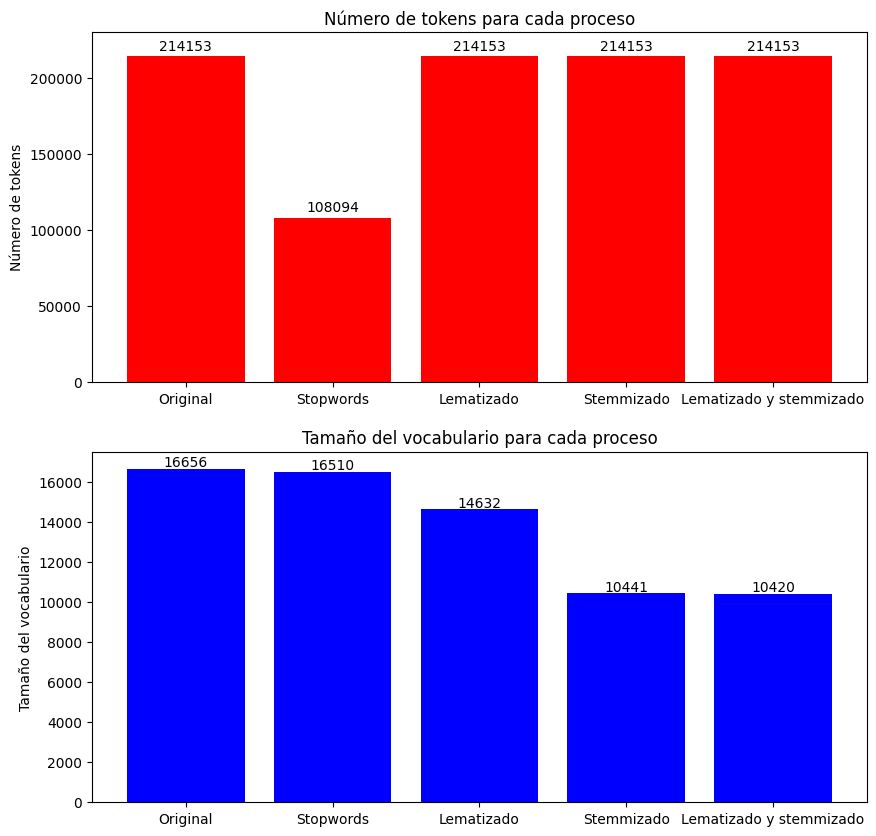

In [ ]:
import matplotlib.pyplot as plt

# Crear una lista de listas con el número de tokens y el tamaño del vocabulario para cada proceso
datos = [[numero_tokens, numero_vocabulario],
         [numero_tokens_sw, numero_vocabulario_sw],
         [numero_tokens_lemmatized, numero_vocabulario_lemmatized],
         [numero_tokens_stemmed, numero_vocabulario_stemmed],
         [numero_tokens_lemstem, numero_vocabulario_lemstem]]

# Crear una lista con los nombres de los procesos
procesos = ['Original', 'Stopwords', 'Lematizado', 'Stemmizado', 'Lematizado y stemmizado']

# Crear una figura con dos subplots, uno para el número de tokens y otro para el tamaño del vocabulario
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Iterar sobre las listas simultáneamente y agregar las barras a los subplots
for i, (tokens, vocabulario) in enumerate(datos):
    ax1.bar(procesos[i], tokens, color='red')
    ax2.bar(procesos[i], vocabulario, color='blue')
    ax1.text(i, tokens+4000, tokens, ha='center', fontsize=10) #
    ax2.text(i, vocabulario+100, vocabulario, ha='center', fontsize=10)

# Añadir títulos y etiquetas a los subplots
ax1.set_title('Número de tokens para cada proceso')
ax1.set_ylabel('Número de tokens')
ax2.set_title('Tamaño del vocabulario para cada proceso')
ax2.set_ylabel('Tamaño del vocabulario')

# Establecer el límite máximo en el eje y de la primera gráfica
ax1.set_ylim(top=230000)

# Mostrar el gráfico
plt.show()


Ya que en las tareas de lematizado y stemizado no se reduce la cantidad de tokens, si no que se lleva al lema o a su raíz, el número de tokens es igual en ese proceso. En el segundo proceso podemos ver que el vocabulario va reduciendo a medida que vamos implementando tareas de stopwords, lematizado, stemmizado y lematizado y stemmizado juntas.

## 6- N-grams

Modifique todas las frases del archivo frases.txt para que tengan una marca de inicio de frase < s > y una marca de fin de frase </ s >. Esto se hace con el fin de que se puedan identificar, en los modelos de lenguaje, las palabras más frecuentes con las que se inician frases y las más frecuentes al final de las mismas. A partir de estos textos, calcule los n-gramas hasta n = 3.

In [ ]:
# Leer el archivo de frases
with open("frases.txt", "r", encoding="utf-8") as file:
    frases = [line.strip() for line in file]

# Agregar las marcas de inicio y fin de frase
frases_modificadas = ["<s> " + frase + " </s>" for frase in frases]

# Guardar las frases modificadas en un archivo
with open("frases_modificadas.txt", "w", encoding="utf-8") as file:
    for frase in frases_modificadas:
        file.write(f"{frase}\n")

# Calcular los n-grams (hasta n=3)
from nltk.util import ngrams

tokens = []
for frase in frases_modificadas:
    for token in frase.split():
        tokens.append(token)

unigramas = list(ngrams(tokens, 1))
bigramas = list(ngrams(tokens, 2))
trigramas = list(ngrams(tokens, 3))

# Imprimir los primeros 10 n-gramas de cada tipo
print("Unigramas:", unigramas[:10])
print("Bigramas:", bigramas[:10])
print("Trigramas:", trigramas[:10])

Unigramas: [('<s>',), ('loomings',), ('</s>',), ('<s>',), ('call',), ('me',), ('ishmael',), ('</s>',), ('<s>',), ('some',)]
Bigramas: [('<s>', 'loomings'), ('loomings', '</s>'), ('</s>', '<s>'), ('<s>', 'call'), ('call', 'me'), ('me', 'ishmael'), ('ishmael', '</s>'), ('</s>', '<s>'), ('<s>', 'some'), ('some', 'years')]
Trigramas: [('<s>', 'loomings', '</s>'), ('loomings', '</s>', '<s>'), ('</s>', '<s>', 'call'), ('<s>', 'call', 'me'), ('call', 'me', 'ishmael'), ('me', 'ishmael', '</s>'), ('ishmael', '</s>', '<s>'), ('</s>', '<s>', 'some'), ('<s>', 'some', 'years'), ('some', 'years', 'ago—never')]


## 7 - Colocaciones
 Empleando el método de información mutua y los bigramas obtenidos en el paso anterior, determine los pares de palabras que podrían ser colocaciones en sus textos.

In [ ]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Crear un objeto BigramAssocMeasures para calcular la información mutua
medida_mi = BigramAssocMeasures() # medida de información mutua

# Crear un objeto BigramCollocationFinder con los tokens de nuestro corpus, él se encarga nuevamente de calcular los bigramas
finder = BigramCollocationFinder.from_words(tokens)

# Filtrar los bigramas por frecuencia mínima y calcular la información mutua
finder.apply_freq_filter(5) # Filtro de frecuencia mínima
bigramas_mi = finder.score_ngrams(medida_mi.mi_like) # Cálculo de información mutua

# Imprimir los 20 bigramas con mayor información mutua
for bigrama, mi in bigramas_mi[:20]:
    print(f"{bigrama[0]} {bigrama[1]} - MI: {mi}")


</s> <s> - MI: 48623.00006169497
<s> and - MI: 202.56329705874597
of the - MI: 57.22117118450212
moby dick - MI: 49.77423822714682
<s> ” - MI: 32.701044708592114
<s> but - MI: 29.431488278747334
in the - MI: 21.61382655894432
<s> the - MI: 18.50935511018294
” said - MI: 10.693059266607166
sperm whale - MI: 8.917821941667421
at last - MI: 6.966230258277508
<s> i - MI: 6.9388543829272935
” cried - MI: 6.608743735400584
to be - MI: 6.485793345481541
” </s> - MI: 5.54603537730718
<s> he - MI: 5.03951736578315
it was - MI: 5.006243075920495
to the - MI: 4.964476312051224
have been - MI: 4.609706801060451
<s> as - MI: 4.392226526973054


## 8- Modelos de lenguaje
Implemente un generador de frases aleatorias utilizando los n-gramas generados en el ítem 6 y sus modelos de lenguaje (y sus probabilidades). Diseñe una estrategia adecuada, por ejemplo, puede determinar de forma aleatoria la palabra inicial de cada frase y completarla a partir de ahí. Además, considere diseñar estrategias de selección de n-gramas para evitar que el generador caiga en bucles o ciclos cerrados.

In [ ]:
def seleccionar_siguiente_token(frase_actual, bigramas, trigramas):
    # Selecciona el siguiente token de la frase actual sabiendo que la frase ya tiene más de un token
    # Para esto, va a elegir aleatoriamente si usar bigramas o trigramas
    if random.random() < 0.5:
        # Si el número aleatorio es menor a 0.5, usar bigramas
        bigramas_posibles = [bigrama for bigrama in bigramas if bigrama[0] == frase_actual[-1]]
        if bigramas_posibles == []:
            # Si no hay bigramas que comiencen con el último token de la frase actual, terminar la frase
            return None
        else:
            # Si hay bigramas que comiencen con el último token de la frase actual, seleccionar uno aleatorio
            return random.choice(bigramas_posibles)[1]
    else:
        # Si el número aleatorio es mayor o igual a 0.5, usar trigramas
        trigramas_posibles = [trigrama for trigrama in trigramas if trigrama[0] == frase_actual[-2] and trigrama[1] == frase_actual[-1]]
        if trigramas_posibles == []:
            # Si no hay trigramas que comiencen con los dos últimos tokens de la frase actual, terminar la frase
            return None
        else:
            # Si hay trigramas que comiencen con los dos últimos tokens de la frase actual, seleccionar uno aleatorio
            return random.choice(trigramas_posibles)[2]


def generar_frase(bigramas, trigramas):
    # Genera una frase a partir de los n-gramas obtenidos en el item 6
    frase = []
    while True:
        if frase == []:
            # Si la frase está vacía, seleccionar una etiqueta de inicio de frase
            frase.append('<s>')
        elif len(frase) == 1:
            # Si la frase tiene un token, mirar cuál es el bigrama que comienza con ese token
            bigramas_posibles = [bigrama for bigrama in bigramas if bigrama[0] == frase[0]]
            if bigramas_posibles == []:
                # Si no hay bigramas que comiencen con ese token, terminar la frase
                break
            else:
                # Si hay bigramas que comiencen con ese token, seleccionar uno aleatorio
                frase.append(random.choice(bigramas_posibles)[1])
        else:
            # Si la frase tiene dos o más tokens, utilizar una función auxiliar para seleccionar el siguiente token
            frase.append(seleccionar_siguiente_token(frase[-2:], bigramas, trigramas))

        if frase[-1] == "</s>":
            # Si el último token de la frase es </s>, terminar la frase
            break

    return " ".join(frase)

# Generar 10 frases
for i in range(10):
    print(generar_frase(bigramas, trigramas))

<s> and her cables </s>
<s> suddenly and his mates thanked god does not felt </s>
<s> broadly gaped—open-mouthed at last rescued him </s>
<s> about that </s>
<s> queens </s>
<s> overflowing </s>
<s> finally: it seemed to add new </s>
<s> warm blankets </s>
<s> or at all their </s>
<s> unsuspected way </s>


## 9- Perplejidad en modelos de lenguaje
Realice el paso 6 nuevamente y calcule modelos de lenguaje a nivel de bigrama (probabilidades de los bigramas), pero esta vez, excluya un documento del corpus de entrada. Use este documento para evaluar la calidad de su modelo de lenguaje empleando la medida de perplejidad. Repita este paso varias veces, pero cada vez con diferentes documentos de evaluación. Compare las medidas de perplejidad y concluya al respecto.

Tenga en cuenta que el texto de evaluación puede contener palabras fuera del vocabulario (OOV); en este caso, sería útil utilizar estrategias de suavizado, como Laplace Smoothing o el método de Backoff. Argumente qué haría en este caso.

### Modelado
Para este punto, se modela el sistema usando suavizado de Laplace debido al tamaño del corpus (pequeño). La perplejidad se calcula usando logaritmos.

In [ ]:
# Mediante una función, A partir de la variable corpus, crear una lista de tokens excluyendo el primer documento
def crear_lista_tokens_excluyendo(corpus, n):
    lista_tokens = []
    for capitulo in corpus:
        if capitulo != corpus[n]:
            frases_capitulo = segmentar_frases(capitulo)
            frases_modificadas = ["<s> " + frase + " </s>" for frase in frases_capitulo]
            for frase in frases_modificadas:
                for token in frase.split():
                    lista_tokens.append(token)
    return lista_tokens

def crear_lista_tokens_capitulo(corpus, n):
    lista_tokens = []
    for capitulo in corpus:
        if capitulo == corpus[n]:
            frases_capitulo = segmentar_frases(capitulo)
            frases_modificadas = ["<s> " + frase + " </s>" for frase in frases_capitulo]
            for frase in frases_modificadas:
                for token in frase.split():
                    lista_tokens.append(token)
    return lista_tokens

tokens = crear_lista_tokens_excluyendo(corpus, 0)

# Calcular bigramas sin el documento excluido
bigramas = list(ngrams(tokens, 2))

# Función para calcular las probabilidades de los bigramas con suavizado de Laplace
def calcular_probabilidades_bigramas(bigramas):
    # print(bigramas[:300])
    # input()
    # Crear un diccionario para guardar las probabilidades
    probabilidades = {}
    # Crear un diccionario para guardar las frecuencias de cada bigrama
    frecuencias = {}
    # Calcular la frecuencia de cada bigrama
    for bigrama in bigramas:
        if bigrama in frecuencias:
            frecuencias[bigrama] += 1
        else:
            frecuencias[bigrama] = 1
    # Calcular la probabilidad de cada bigrama
    aux = len(set(bigramas))
    for bigrama in frecuencias:
        # suavizado de Laplace consiste en sumar 1 al numerador y el tamaño del vocabulario al denominador
        probabilidades[bigrama] = (frecuencias[bigrama] + 1) / (len(bigramas) + aux)
    return probabilidades

# Calcular las probabilidades de los bigramas
probabilidades_bigramas = calcular_probabilidades_bigramas(bigramas)

# Calcular la perplejidad del documento excluido
def calcular_perplejidad(frase, n, probabilidades_bigramas):
    # Crear una lista de tokens del documento excluido
    tokens = crear_lista_tokens_capitulo(frase, n)
    # Calcular los bigramas del documento excluido
    bigramas = list(ngrams(tokens, 2))
    # Calcular la perplejidad
    perplejidad = 1
    for bigrama in bigramas:
        if bigrama in probabilidades_bigramas:
            perplejidad += math.log2(probabilidades_bigramas[bigrama])
        else:
            perplejidad += math.log2(1 / len(bigramas))
    perplejidad = 2 ** (-perplejidad / len(bigramas))
    return perplejidad

# Ejemplo para probar las funciones
frase_corpus = 'wharves as indian isles by coral reefs—commerce surrounds it with her'
tokens_frase_corpus = frase_corpus.split()
perplejidad = calcular_perplejidad(tokens_frase_corpus, 0, probabilidades_bigramas)
print('perplejidad frase del corpus de test: ', perplejidad)

perplejidad frase del corpus de test:  308.07628925316544


## 10- Implementación de un corrector ortográfico
Implemente un módulo de corrección ortográfica para su sistema. Puede utilizar sistemas ya diseñados, como pyspellchecker (https://pypi.org/project/pyspellchecker/), o adaptar la función de distancia de edición mínima. El sistema puede requerir interacción con el usuario si así lo desea, o diseñar un módulo de decisión sobre la sustitución (por ejemplo, sustituir siempre por la palabra más probable).

In [ ]:
# importar spellchecker
from spellchecker import SpellChecker

# Crear una función que implemente un modulo de corrección ortográfica dado un texto
def corregir_ortografia(tokens):
    spell = SpellChecker()
    tokens_corregidos = []
    for token in tokens:
        if token not in spell:
            print('Token a corregir: ',token)
            decision = input('¿Desea corregir este token? (s/n) Si desea salir escriba Esc')
            if decision == 's':
                print(spell.correction(token))
                token = spell.correction(token)

            elif(decision == 'Esc'):
                break

            else:
                print('No se corrigió el token')

        tokens_corregidos.append(token)

    return tokens_corregidos

# print(corpus[0][:500])

# Tokenizar texto usando nltk
tokens_0 = nltk.word_tokenize(corpus[0])

print('texto normalizado: ', tokens_corpus[:500])

# Corregir ortografía de tokens
tokens_0_corregidos = corregir_ortografia(tokens_corpus)

texto normalizado:  ['loomings', 'call', 'me', 'ishmael', 'some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', 'it', 'is', 'a', 'way', 'i', 'have', 'of', 'driving', 'off', 'the', 'spleen', 'and', 'regulating', 'the', 'circulation', 'whenever', 'i', 'find', 'myself', 'growing', 'grim', 'about', 'the', 'mouth', 'whenever', 'it', 'is', 'a', 'damp', 'drizzly', 'november', 'in', 'my', 'soul', 'whenever', 'i', 'find', 'myself', 'involuntarily', 'pausing', 'before', 'coffin', 'warehouses', 'and', 'bringing', 'up', 'the', 'rear', 'of', 'every', 'funeral', 'i', 'meet', 'and', 'especially', 'whenever', 'my', 'hypos', 'get', 'such', 'an', 'upper', 'hand', 'of', 'me', 'that', 'it', 'requires', 'a', 'strong', 'moral', 'principle', 

## 11- Representación en el modelo de espacio vectorial

Genere un listado de los index-terms de sus textos (puede emplear el mismo vocabulario que determinó en el paso 5). A partir de este listado, represente todos los documentos de su corpus en el modelo de espacio vectorial.

En esta celda a colab le toma un buen tiempo (al rededor de 2 minutos) para terminar de ejecutar.

In [ ]:
# Index terms del punto 5: Se toman los tokens que no son stopwords
index_terms = list(vocabulario_sw)

# Crear una función que represente un documento en el modelo de espacio vectorial
def matriz_de_terminos(corpus, index_terms):
    # Crear una matriz de ceros con las dimensiones del corpus y el vocabulario
    matriz = np.zeros((len(corpus), len(index_terms)))
    # Recorrer el corpus
    for i, capitulo in enumerate(corpus):
        # Crear una lista de tokens del capítulo
        tokens = nltk.word_tokenize(capitulo)
        # Recorrer los tokens del capítulo
        for token in tokens:
            # Si el token está en el vocabulario
            if token in index_terms:
                # Calcular la frecuencia del token en el capítulo
                frecuencia = tokens.count(token)
                # Obtener el índice del token en el vocabulario
                indice = index_terms.index(token)
                # Asignar la frecuencia del token en el capítulo en la matriz
                matriz[i, indice] = frecuencia
    return matriz

# Representar los documentos en el modelo de espacio vectorial
mdt = matriz_de_terminos(corpus, index_terms)

# Crear un dataframe que permita visualizar la matriz de términos del corpus
# print(index_terms.shape)
df_mdt = pd.DataFrame(mdt, columns=list(index_terms), index=['doc'+str(i) for i in range(1, len(corpus)+1)])
print('MATRIZ DE TÉRMINOS')
print(df_mdt)

# Mirar cuáles son los termino qué más se repiten en el corpus usando la matriz de términos
print(df_mdt.sum(axis=0).sort_values(ascending=False))

MATRIZ DE TÉRMINOS
        lar  hatchet  roughly  chapter  opportunity  fortunately  exploding  \
doc1    0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc2    0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc3    1.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc4    0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc5    0.0      0.0      0.0      0.0          0.0          0.0        0.0   
...     ...      ...      ...      ...          ...          ...        ...   
doc131  0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc132  0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc133  0.0      0.0      0.0      0.0          0.0          0.0        0.0   
doc134  0.0      0.0      0.0      0.0          1.0          0.0        0.0   
doc135  0.0      0.0      0.0      0.0          0.0          0.0        0.0   

        predestinating  latitude

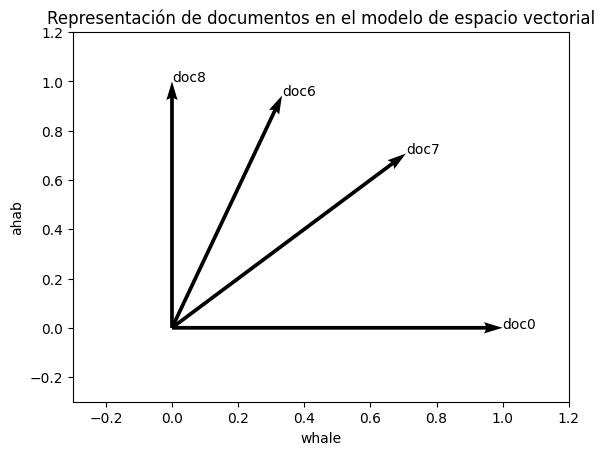

In [ ]:
# Obtener un array de 'whale' en la matriz de términos
array_whale = df_mdt.loc[:, 'whale'].values

# Obtener un array de 'ahab' en la matriz de términos
array_ahab = df_mdt.loc[:, 'ahab'].values

# Hacer un array que contenga los pares coordenados de 'whale' y 'ahab'
array_coordenadas = np.array([array_whale, array_ahab]).T

# Normalizar cada coordenada dentro de array_coordenadas
array_coordenadas_normalizadas = [x/np.linalg.norm(x) for x in array_coordenadas if np.linalg.norm(x) != 0]

# Plot de las coordenadas normalizadas usando vectores unitarios para cada coordenada
def plot_coordenada_mdt(coordenada, texto):
    plt.quiver(0, 0, coordenada[0], coordenada[1], scale=1, scale_units='xy', angles='xy')
    plt.text(coordenada[0], coordenada[1], texto)
    plt.xlim(-0.3, 1.2)
    plt.ylim(-0.3, 1.2)
    plt.xlabel('whale')
    plt.ylabel('ahab')
    plt.title('Representación de documentos en el modelo de espacio vectorial')

flag1, flag2 = True, True
# Plot de las coordenadas normalizadas
for i, coordenada in enumerate(array_coordenadas_normalizadas[:10]):
    if coordenada[0] == 0 and coordenada[1] == 1 and flag1:
        plot_coordenada_mdt(coordenada, 'doc'+str(i))
        flag1 = False
    if coordenada[0] == 1 and coordenada[1] == 0 and flag2:
        plot_coordenada_mdt(coordenada, 'doc'+str(i))
        flag2 = False
    if coordenada[0] != 0 and coordenada[1] != 0:
        plot_coordenada_mdt(coordenada, 'doc'+str(i))

## 12- Grado de Similitud: Distancia Coseno

Calcule el grado de similitud entre todos los documentos de su corpus empleando la medida de la distancia coseno (o medida de similitud coseno).

SIMILITUD COSENO ENTRE DOCUMENTOS (RECORTADA A 5 x 5)
          doc1      doc2      doc3      doc4      doc5
doc1  1.000000  0.296517  0.378439  0.291716  0.303285
doc2  0.296517  1.000000  0.411413  0.282169  0.200764
doc3  0.378439  0.411413  1.000000  0.451332  0.354063
doc4  0.291716  0.282169  0.451332  1.000000  0.265325
doc5  0.303285  0.200764  0.354063  0.265325  1.000000


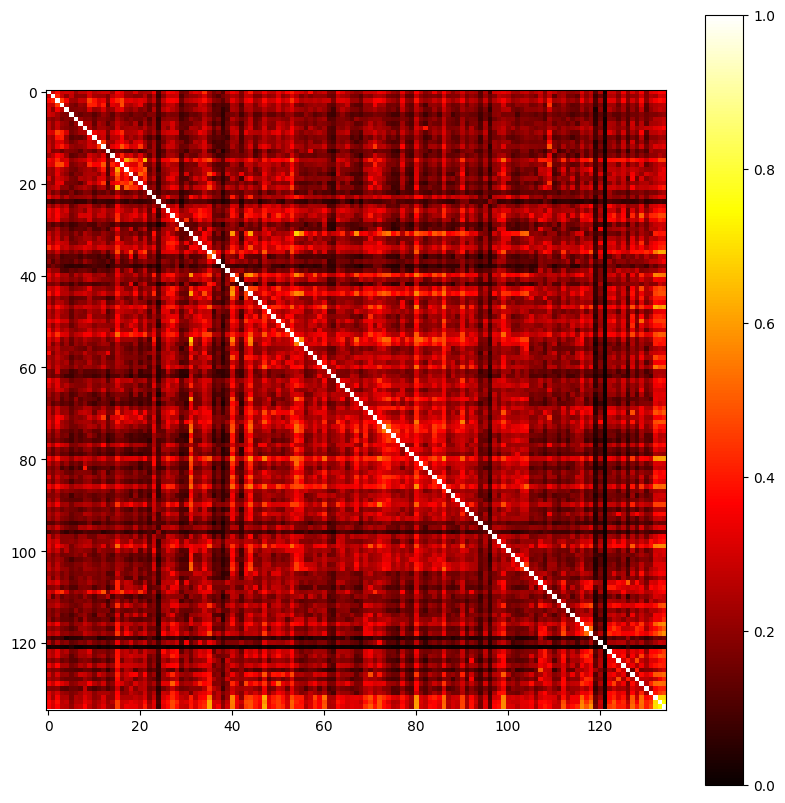

In [ ]:
# Calcule el grado de similitud entre todos los documentos de su corpus empleando la medida de la distancia
# coseno (o medida de similitud coseno).

# Crear una función que calcule la similitud coseno entre dos vectores
def similitud_coseno(v1, v2):
    # Calcular el producto punto entre los vectores
    producto_punto = np.dot(v1, v2)
    # Calcular la norma de v1
    norma_v1 = np.linalg.norm(v1)
    # Calcular la norma de v2
    norma_v2 = np.linalg.norm(v2)
    # Calcular la similitud coseno
    similitud = producto_punto/(norma_v1*norma_v2)
    return similitud


# Crear un dataframe del tamaño de los capitulos en el corpus
df_similitud = pd.DataFrame(np.zeros((len(corpus), len(corpus))), columns=['doc'+str(i) for i in range(1, len(corpus)+1)], index=['doc'+str(i) for i in range(1, len(corpus)+1)])

# Calcular la similitud coseno entre todos los documentos del corpus
for i in range(len(corpus)):
    for j in range(len(corpus)):
        df_similitud.iloc[i, j] = similitud_coseno(mdt[i, :], mdt[j, :])

# Visualizar la similitud coseno entre todos los documentos del corpus
print('SIMILITUD COSENO ENTRE DOCUMENTOS (RECORTADA A 5 x 5)')
# imprimir solamente la matriz recortada a 10 x 10
print(df_similitud.iloc[:5, :5])

import seaborn as sns
import matplotlib.pyplot as plt

# Crear mapa de calor con la matriz de similitud de coseno usando imshow de matplotlib que se vea grande
plt.figure(figsize=(10, 10))
plt.imshow(df_similitud, cmap='hot', interpolation='nearest') # interpolation sirve para que se vea más suave
plt.colorbar()


# Mostrar mapa de calor
plt.show()

En este mapa de calor se representa la matriz de similitud coseno entre todos los documentos. Se puede observar la diagonal de la matriz, que representa la similitud de un documento consigo mismo, la cual es 1.0. También se puede observar que la matriz es simétrica, ya que la similitud entre dos documentos es la misma sin importar el orden en el que se calcula. Observese también el documento 120 y su diferencia con cada uno de los demás documentos, esto se puede deber a que este capítulo de los que menos palabras tiene, por lo que su similitud con los demás es menor. Notese también la similitud existente entre los últimos tres capítulos (sector amarillo en la esquina inferior derecha), esto se debe a que estos capítulos hablan de la caza de la ballena, por lo que tienen un vocabulario y temática similar.

## 13 y 14- LSA y clasificador K-means

Lleve su corpus a un espacio LSA. Conserve un número reducido de dimensiones.

In [ ]:
# Función que emplee diferentes esquemas de ponderado a la matriz de términos
from sklearn.metrics import silhouette_score


def esquemas_ponderado(mdt, esquema):
    # Crear una matriz de ceros con las dimensiones del corpus y el vocabulario
    matriz = np.zeros((len(corpus), len(index_terms)))
    # Recorrer la matriz de términos
    for i in range(mdt.shape[0]):
        for j in range(mdt.shape[1]):
            if esquema == 'binario':
                if mdt[i, j] > 0:
                    matriz[i, j] = 1
                else:
                    matriz[i, j] = 0

            elif esquema == 'tf':
                matriz[i, j] = mdt[i, j]

            elif esquema == 'tfidf':
                if mdt[i, j] > 0:
                    matriz[i, j] = mdt[i, j]*np.log(len(corpus)/df_mdt.iloc[j, :].sum())
                else:
                    matriz[i, j] = 0


            elif esquema == 'log':
                if mdt[i, j] > 0:
                    matriz[i, j] = 1 + np.log(mdt[i, j])
                else:
                    matriz[i, j] = 0

    return matriz

# Calcular la matriz de términos ponderada con el esquema binario
# matriz = esquemas_ponderado(mdt, 'binario')
# matriz = matriz_binaria.T

# Calcular la matriz de términos ponderada con el esquema tf
# matriz = esquemas_ponderado(mdt, 'tf')

# # Calcular la matriz de términos ponderada con el esquema tfidf
matriz = esquemas_ponderado(mdt, 'binario')

# # Calcular la matriz de términos ponderada con el esquema log
# matriz = esquemas_ponderado(mdt, 'log')


datos_silueta = []
componentes_a_probar = [30, 35, 40]
clusters_a_probar = [2, 3, 4]

for numero_componentes in range(2, 30, 5):
    # Aplicar LSA
    lsa = TruncatedSVD(n_components=numero_componentes)
    matriz_lsa = lsa.fit_transform(matriz.T)
    print('Matriz LSA con', numero_componentes, 'componentes')

    silueta = []
    for numero_clusters in clusters_a_probar:
        # Clustering con k-means
        kmeans = KMeans(n_clusters=numero_clusters, random_state=0, n_init=10)
        kmeans.fit(matriz_lsa)

        # Asignar clusters a los documentos
        clusters = kmeans.predict(matriz_lsa)

        # Calcular coeficiente de silueta para evaluar el clustering con k-means
        coeficiente_silueta = silhouette_score(matriz_lsa, clusters)

        # guardar los resultados del coeficiente de silueta en función del número de clusters y componentes en un arreglo 3D
        silueta.append(coeficiente_silueta)

    datos_silueta.append(silueta)
    print('Para LSA =', numero_componentes, 'los coeficientes de silueta son:', silueta)





Matriz LSA con 2 componentes
Para LSA = 2 los coeficientes de silueta son: [0.849358313069541, 0.7330465370438444, 0.6519379321847623]
Matriz LSA con 7 componentes
Para LSA = 7 los coeficientes de silueta son: [0.7705127898377532, 0.6150315361677984, 0.5030714944525965]
Matriz LSA con 12 componentes
Para LSA = 12 los coeficientes de silueta son: [0.7318513667288157, 0.5841781887634503, 0.4185304984670214]
Matriz LSA con 17 componentes
Para LSA = 17 los coeficientes de silueta son: [0.7071884001389577, 0.5570106502086786, 0.366335615245734]
Matriz LSA con 22 componentes
Para LSA = 22 los coeficientes de silueta son: [0.6899279000510792, 0.5383114492850082, 0.32650397313785234]
Matriz LSA con 27 componentes
Para LSA = 27 los coeficientes de silueta son: [0.6795214342971776, 0.5265692259345911, 0.2960075328017518]


A partir de los resultados del coeficiente de silueta, podemos ver que tomando dos dimensiones se obtiene el mejor resultado.

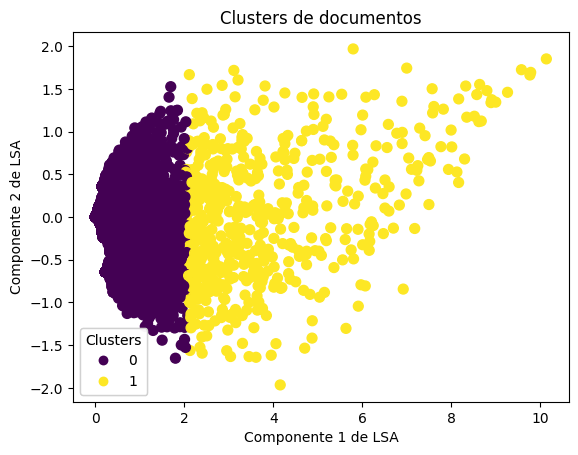

In [ ]:
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(matriz_lsa)

# Asignar clusters a los documentos
clusters = kmeans.predict(matriz_lsa)

# Graficar clusters
scatter = plt.scatter(matriz_lsa[:, 0], matriz_lsa[:, 1], c=clusters, s=50, cmap='viridis')
plt.title('Clusters de documentos')
plt.xlabel('Componente 1 de LSA')
plt.ylabel('Componente 2 de LSA')

# Agregar leyenda
legend1 = plt.legend(*scatter.legend_elements(),
                     loc="lower left", title="Clusters")
plt.gca().add_artist(legend1)

# Agregar etiquetas de documentos
for i, txt in enumerate(['doc'+str(i) for i in range(1, len(corpus)+1)]):
    if i == 53: plt.annotate(txt, (matriz_lsa[i, 0]-2.7, matriz_lsa[i, 1]))

plt.show()

Esta clasificación está basada en la propia acomodación de los datos. Nótese que el cluster 0 está mucho más cohesionado que el cluster 1. Esto se puede deber a diferentes factores, como por ejemplo que el cluster 0 tenga más documentos que el cluster 1, o que los documentos del cluster 0 sean más similares entre sí que los del cluster 1.

## 15- MDS

Implemente un MDS (Multidimensional scaling) en su corpus original y compare los resultados con los obtenidos en el  ́ıtem anterior.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


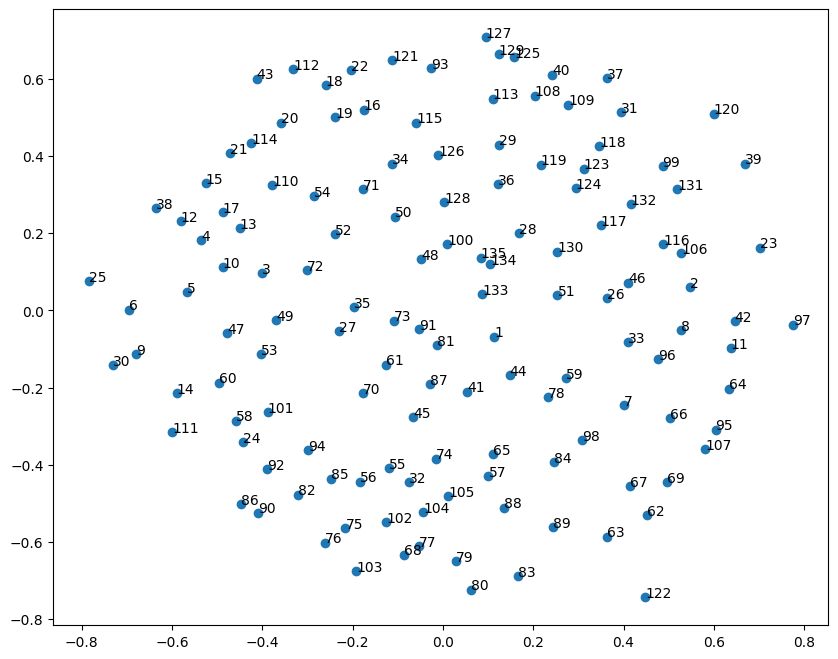

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# Asumamos que `capitulos` es tu lista de capitulos del cuento

# Creamos un lematizador y obtenemos las stopwords en inglés
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocesar(texto):
    # Convertir a minúsculas y eliminar puntuación
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))

    # Tokenizar, lematizar y eliminar stopwords
    palabras = [lemmatizer.lemmatize(palabra) for palabra in word_tokenize(texto) if not palabra in stop_words]

    return ' '.join(palabras)

# Preprocesamos los capítulos
capitulos_preprocesados = [preprocesar(capitulo) for capitulo in corpus]

# Calculamos el modelo tf-idf
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf = vectorizer.fit_transform(capitulos_preprocesados)

# Calculamos las distancias entre cada par de capítulos
distancias = cosine_distances(tfidf)

# Realizamos el MDS
mds = MDS(dissimilarity='precomputed')
coords = mds.fit_transform(distancias)

# Ahora `coords` es una lista de coordenadas 2D, cada una correspondiente a un capítulo

# Extraemos las coordenadas x e y de cada punto
x_coords = coords[:, 0]
y_coords = coords[:, 1]

# Creamos un gráfico de dispersión
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords)

# Etiquetamos cada punto con el número de su capítulo
for i, (x, y) in enumerate(coords):
    plt.text(x, y, i+1)  # asumimos que el primer capítulo es el número 1

plt.show()



Análisis de los resultados del MDS:

A partir del análisis realizado, se observa que los datos presentan una distribución bastante uniforme. Esto podría atribuirse a la consistencia en el estilo de escritura y al uso repetitivo de ciertos vocabularios a lo largo del libro, lo que hace que los capítulos sean menos distinguibles cuando se visualizan a través del MDS.

Un aspecto que destaca es el capítulo 122, el cual se aleja notablemente de los demás en la representación MDS. Este capítulo, compuesto por tan solo 7 renglones, es significativamente más corto que el resto, lo que puede explicar su distanciamiento en la representación gráfica. Su brevedad podría dar lugar a un conjunto de palabras y temas más limitado, lo que resulta en una representación TF-IDF distinta a la de los capítulos más extensos.

Otra observación interesante se centra en los capítulos 133, 134 y 135, que se agrupan estrechamente en el gráfico. Estos capítulos, siendo los finales, tratan sobre la caza de la ballena. Este hallazgo sugiere que el MDS está capturando de manera efectiva las similitudes temáticas entre estos capítulos, subrayando su continuidad en el tratamiento de la caza de la ballena.

En general, estos resultados ofrecen un valioso indicio de que el MDS, a pesar de la aparente uniformidad, es capaz de detectar y reflejar diferencias y similitudes sutiles en la estructura temática de los capítulos del libro.